In [1]:
import logging
import math
from dataclasses import dataclass
from pathlib import Path
from typing import List, Collection, Callable, Tuple, Set

import click
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import numpy as np
import pandas as pd
from bokeh.io import output_notebook, show
from bokeh.models import (
    Range1d,
    Plot,
    Circle,
    MultiLine,
    LinearColorMapper,
    ColorBar,
    BasicTicker,
    HoverTool,
    BoxZoomTool,
    ResetTool,
    PanTool,
    WheelZoomTool,
    UndoTool,
    SaveTool,
    ColumnDataSource,
    LabelSet,
)
from bokeh.palettes import inferno, Category20
from bokeh.plotting import from_networkx
from scipy import stats

WIDTH = 1280
HEIGHT = 720
DELIM = ","
PAIR_IDX = ("sample1", "sample2")
PALETTE = Category20[20] * 10  # effectively 10 cycles of 20 colours


class AsymmetrixMatrixError(Exception):
    pass


@dataclass
class ConfusionMatrix:
    tp: int = 0
    tn: int = 0
    fp: int = 0
    fn: int = 0

    def ravel(self) -> Tuple[int, int, int, int]:
        """Return the matrix as a flattened tuple.
        The order of return is TN, FP, FN, TP
        """
        return self.tn, self.fp, self.fn, self.tp

    def as_matrix(self) -> np.ndarray:
        """Returns a 2x2 matrix [[TN, FP], [FN, TP]]"""
        return np.array([[self.tn, self.fp], [self.fn, self.tp]])

    def precision(self) -> float:
        """Also known as positive predictive value (PPV)"""
        return self.tp / (self.tp + self.fp)

    def recall(self) -> float:
        """Also known as true positive rate (TPR)"""
        return self.tp / (self.tp + self.fn)

    def fowlkes_mallows_index(self) -> float:
        """Geometric mean between precision and recall"""
        return math.sqrt(self.precision() * self.recall())

    def f_score(self, beta: float = 1.0) -> float:
        """Harmonic mean of precision and recall.
        When beta is set to 0, you get precision. When beta is set to 1, you get the
        unweighted F-score which is the harmonic mean of precision and recall. Setting
        beta to 2 weighs recall twice as much as precision. Setting beta to 0.5 weighs
        precision twice as much as recall.
        """
        ppv = self.precision()
        tpr = self.recall()
        beta2 = beta ** 2

        return ((beta2 + 1) * ppv * tpr) / ((beta2 * ppv) + tpr)

    def matthews_correlation_coefficient(self) -> float:
        """A correlation coefficient between the observed and predicted binary
        classifications.
        """
        tn, fp, fn, tp = self.ravel()
        numerator = tp * tn - fp * fn
        denominator = math.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
        return numerator / denominator
    
    @staticmethod
    def from_predictions(pred: List[bool], truth: List[bool]) -> "ConfusionMatrix":
        assert len(pred) == len(truth)
        mtx = [[0, 0], [0, 0]]
        for y_true, y_pred in zip(truth, pred):
            mtx[y_true][y_pred] += 1
        [tn, fp], [fn, tp] = mtx
        return ConfusionMatrix(tp=tp, tn=tn, fp=fp, fn=fn)


def parse_threshold(ctx, param, value):
    try:
        return [int(t) for t in value.split(",")]
    except ValueError:
        raise click.BadParameter(
            "threshold values must be integers, and if providing multiple, must be comma-separated"
        )


def parse_samples(ctx, param, value):
    return value.split(",")


def load_matrix(fpath, delim: str = DELIM, name: str = "") -> pd.Series:
    matrix = []
    with open(fpath) as instream:
        header = next(instream).rstrip()
        names = np.array(header.split(delim)[1:])
        idx = np.argsort(names)
        sorted_names = names[idx]
        for row in map(str.rstrip, instream):
            # sort row according to the name sorting
            sorted_row = np.array(row.split(delim)[1:], dtype=np.int)[idx]
            matrix.append(sorted_row)

    sorted_matrix = np.array(matrix)[idx]
    n_samples = len(sorted_names)
    diagonal_is_zero = all(sorted_matrix[i, i] == 0 for i in range(n_samples))
    if not diagonal_is_zero:
        raise AsymmetrixMatrixError("Distance matrix diagonal is not all zero")

    matrix_is_symmetric = np.allclose(sorted_matrix, sorted_matrix.T)
    if not matrix_is_symmetric:
        raise AsymmetrixMatrixError("Distance matrix is not symmetric")

    mx = pd.DataFrame(sorted_matrix, columns=sorted_names, index=sorted_names)
    # remove the lower triangle of the matrix and the middle diagonal
    mx = mx.where(np.triu(np.ones(mx.shape), k=1).astype(np.bool))
    mx = mx.stack().rename(name).astype(int)
    mx = mx.rename_axis(PAIR_IDX)

    return mx


def dist_matrix_to_graph(mx: pd.Series, threshold: int) -> nx.Graph:
    edges = [(s1, s2, dist) for (s1, s2), dist in mx.iteritems() if dist <= threshold]
    graph = nx.Graph()
    graph.add_weighted_edges_from(edges)
    return graph


def fit(xs: List[int], ys: List[int]) -> Callable:
    """Determines the line of best fit for the given distances and returns the linear equation
    as a function that takes a threshold, x, and returns the equivalent threshold for the data
    passed to this function.
    Note: xs should be the 'truth' distance values"""
    slope, intercept, rvalue, pvalue, stderr = stats.linregress(xs, ys)

    def threshold_converter(threshold: float) -> float:
        """y = mx + c, where x is the threshold"""
        return slope * threshold + intercept

    return threshold_converter


def plot_graph(
    graph: nx.Graph, threshold: int, height: int = 600, width: int = 900, name: str = ""
) -> None:
    title = f"{name} clusters"
    # inline effectively allows the plot to work offline
#     output_file(str(outfile), title=title, mode="inline")

    edge_attrs = {}
    cmap = inferno(threshold + 1)

    for u, v, d in graph.edges(data=True):
        edge_colour = cmap[d["weight"]]
        edge_attrs[(u, v)] = edge_colour

    nx.set_edge_attributes(graph, edge_attrs, "edge_colour")

    node_attrs = {}
    clusters = (graph.subgraph(c) for c in nx.connected_components(graph))
    for i, cluster in enumerate(clusters):
        colour = "#e5e9f0"
        for v in cluster.nodes:
            node_attrs[v] = colour

    nx.set_node_attributes(graph, node_attrs, "node_colour")

    pos = nx.nx_agraph.graphviz_layout(graph, prog="neato")
    xmin = -5
    xmax = max((x for (x, _) in pos.values())) * 1.05
    xrange = Range1d(xmin, xmax)
    ymin = -5
    ymax = max((y for (_, y) in pos.values())) * 1.05
    yrange = Range1d(ymin, ymax)

    plot = Plot(plot_width=width, plot_height=height, x_range=xrange, y_range=yrange)
    plot.title.align = "center"
    plot.title.text = title

    graph_renderer = from_networkx(graph, pos)
    graph_renderer.node_renderer.glyph = Circle(
        size=40, fill_color="node_colour", line_alpha=0.2
    )
    graph_renderer.edge_renderer.glyph = MultiLine(
        line_width=6, line_color="edge_colour", line_alpha=0.9
    )
    plot.renderers.append(graph_renderer)

    cmapper = LinearColorMapper(palette="Inferno256", low=0, high=threshold)
    color_bar = ColorBar(
        color_mapper=cmapper,
        major_label_text_font_size="14px",
        ticker=BasicTicker(desired_num_ticks=threshold),
        label_standoff=6,
        major_label_text_baseline="middle",
        border_line_color=None,
        location=(0, 0),
        title="SNP distance",
        title_text_align="center",
        title_standoff=10,
    )
    plot.add_layout(color_bar, "right")

    node_hover_tool = HoverTool(
        tooltips=[("sample", "@index")],
    )
    plot.add_tools(
        node_hover_tool,
        BoxZoomTool(),
        ResetTool(),
        PanTool(),
        WheelZoomTool(),
        UndoTool(),
        SaveTool(),
    )

    labels = []
    x_vals = []
    y_vals = []
    for lab, (x, y) in pos.items():
        labels.append(lab)
        x_vals.append(x)
        y_vals.append(y)

    d = {"labels": labels, "x_values": x_vals, "y_values": y_vals}
    src = ColumnDataSource(d)

    label_set = LabelSet(
        source=src,
        x="x_values",
        y="y_values",
        text="labels",
        y_offset=-5,
        text_align="center",
        text_font_size="10px",
        text_font_style="bold",
        text_color="black",
        text_font="monospace",
    )
    plot.add_layout(label_set)

    show(plot)
output_notebook()

def connected_components(G: nx.Graph, node: str) -> Set[str]:
    if node not in G:
        return set()
    return nx.node_connected_component(G, node)

def clustered_together(u: str, v: str, G: nx.Graph) -> bool:
    ucc = connected_components(G, u)
    if not ucc:
        return False
    
    vcc = connected_components(G, v)
    if not vcc:
        return False
    
    return ucc == vcc

def plot_confusion_matrix(cm: ConfusionMatrix, name: str, figsize: Tuple[int, int] = (13, 8), dpi: int=300):
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    #Plot the matrix
    sns.heatmap(cm.as_matrix(), annot=True, fmt = "d", cmap="Blues")

    # labels, title and ticks
    ax.set_ylabel('True')
    ax.set_xlabel('Predicted') 
    ax.set_title('bcftools Clustering of Pairs - Confusion Matrix')
    ax.xaxis.set_ticklabels(['Negative', 'Positive'])
    ax.yaxis.set_ticklabels(['Negative', 'Positive'])
    return fig

Loading BokehJS ...

# Clustering

The first thing we do is set the base SNP distance threshold for the Illumina data.

In [2]:
THRESHOLD = 12

Next, we set the SNP distance threshold for data we want to construct our adaptive threshold for Nanopore data from. What this means is, for an adaptive threshold $A$, we restrict to only pairs of samples with a COMPASS (Illumina) SNP distance $\leq A$.

In [3]:
adaptive_threshold = 100

We load the COMPASS distance matrix in and reduce it to those pairs within the adaptive threshold.

In [4]:
compass_mtx = load_matrix("compass.matrix.csv", name="compass")
ix = compass_mtx < adaptive_threshold
compass_mtx = compass_mtx[ix]

We now create a graph of this COMPASS distance matrix. We actually build the graph by restricting to only those sample pairs that are less than or equal to our baseline threshold and add an edge between them in the graph.

In [5]:
G_compass = dist_matrix_to_graph(compass_mtx, threshold=THRESHOLD)
plot_graph(G_compass, threshold=THRESHOLD, name="COMPASS")

## `bcftools`

Let's investigate the clustering produce by `bcftools`' nanopore calls.

In [6]:
bcftools_mtx = load_matrix("bcftools.matrix.csv", name="bcftools")[ix]
assert all(compass_mtx.index == bcftools_mtx.index)

To get an equivalent SNP distance threshold for nanopore data, we fit a linear regression to the pairwise distances produced by COMPASS (x) and the same distances from the `bcftools` calls (y).

In [7]:
xs = compass_mtx.to_list()
ys = bcftools_mtx.to_list()
bcftools_threshold_converter = fit(xs, ys)
bcftools_threshold = bcftools_threshold_converter(THRESHOLD)
print(f"The bcftools SNP distance threshold is {bcftools_threshold:.2f} - rounded to {int(round(bcftools_threshold))}")
bcftools_threshold = int(round(bcftools_threshold))

The bcftools SNP distance threshold is 10.77 - rounded to 11


Let's take a look at the clustering this threshold produces on the `bcftools` data

In [8]:
G_bcftools = dist_matrix_to_graph(bcftools_mtx, threshold=bcftools_threshold)
plot_graph(G_bcftools, threshold=bcftools_threshold, name="bcftools")

As elaborated [here](https://github.com/mbhall88/head_to_head_pipeline/issues/65#issuecomment-790368373) we can build a confusion matrix from this clustering to get a better sense of how "good" these clusters are.  
For each pair of samples in the graph (including singletons not shown in the above plot), are these two samples clustered together?
- **True Positive (TP)**: the pair **is** clustered in the truth (COMPASS) and also in the predicted (i.e. `bcftools`)
- **True Negative (TN)**:  the pair **is not** clustered in the truth and also in the predicted 
- **False Positive (FP)**: the pair **is not** clustered in the truth but **is** clustered in the predicted
- **False Negative (FN)**: the pair **is** clustered in the truth but **is not** clustered in the predicted

In [9]:
true: List[bool] = [clustered_together(u, v, G_compass) for u, v in compass_mtx.index]
pred: List[bool] = [clustered_together(u, v, G_bcftools) for u, v in compass_mtx.index]
cm = ConfusionMatrix.from_predictions(pred, true)
cm

ConfusionMatrix(tp=69, tn=143, fp=45, fn=2)

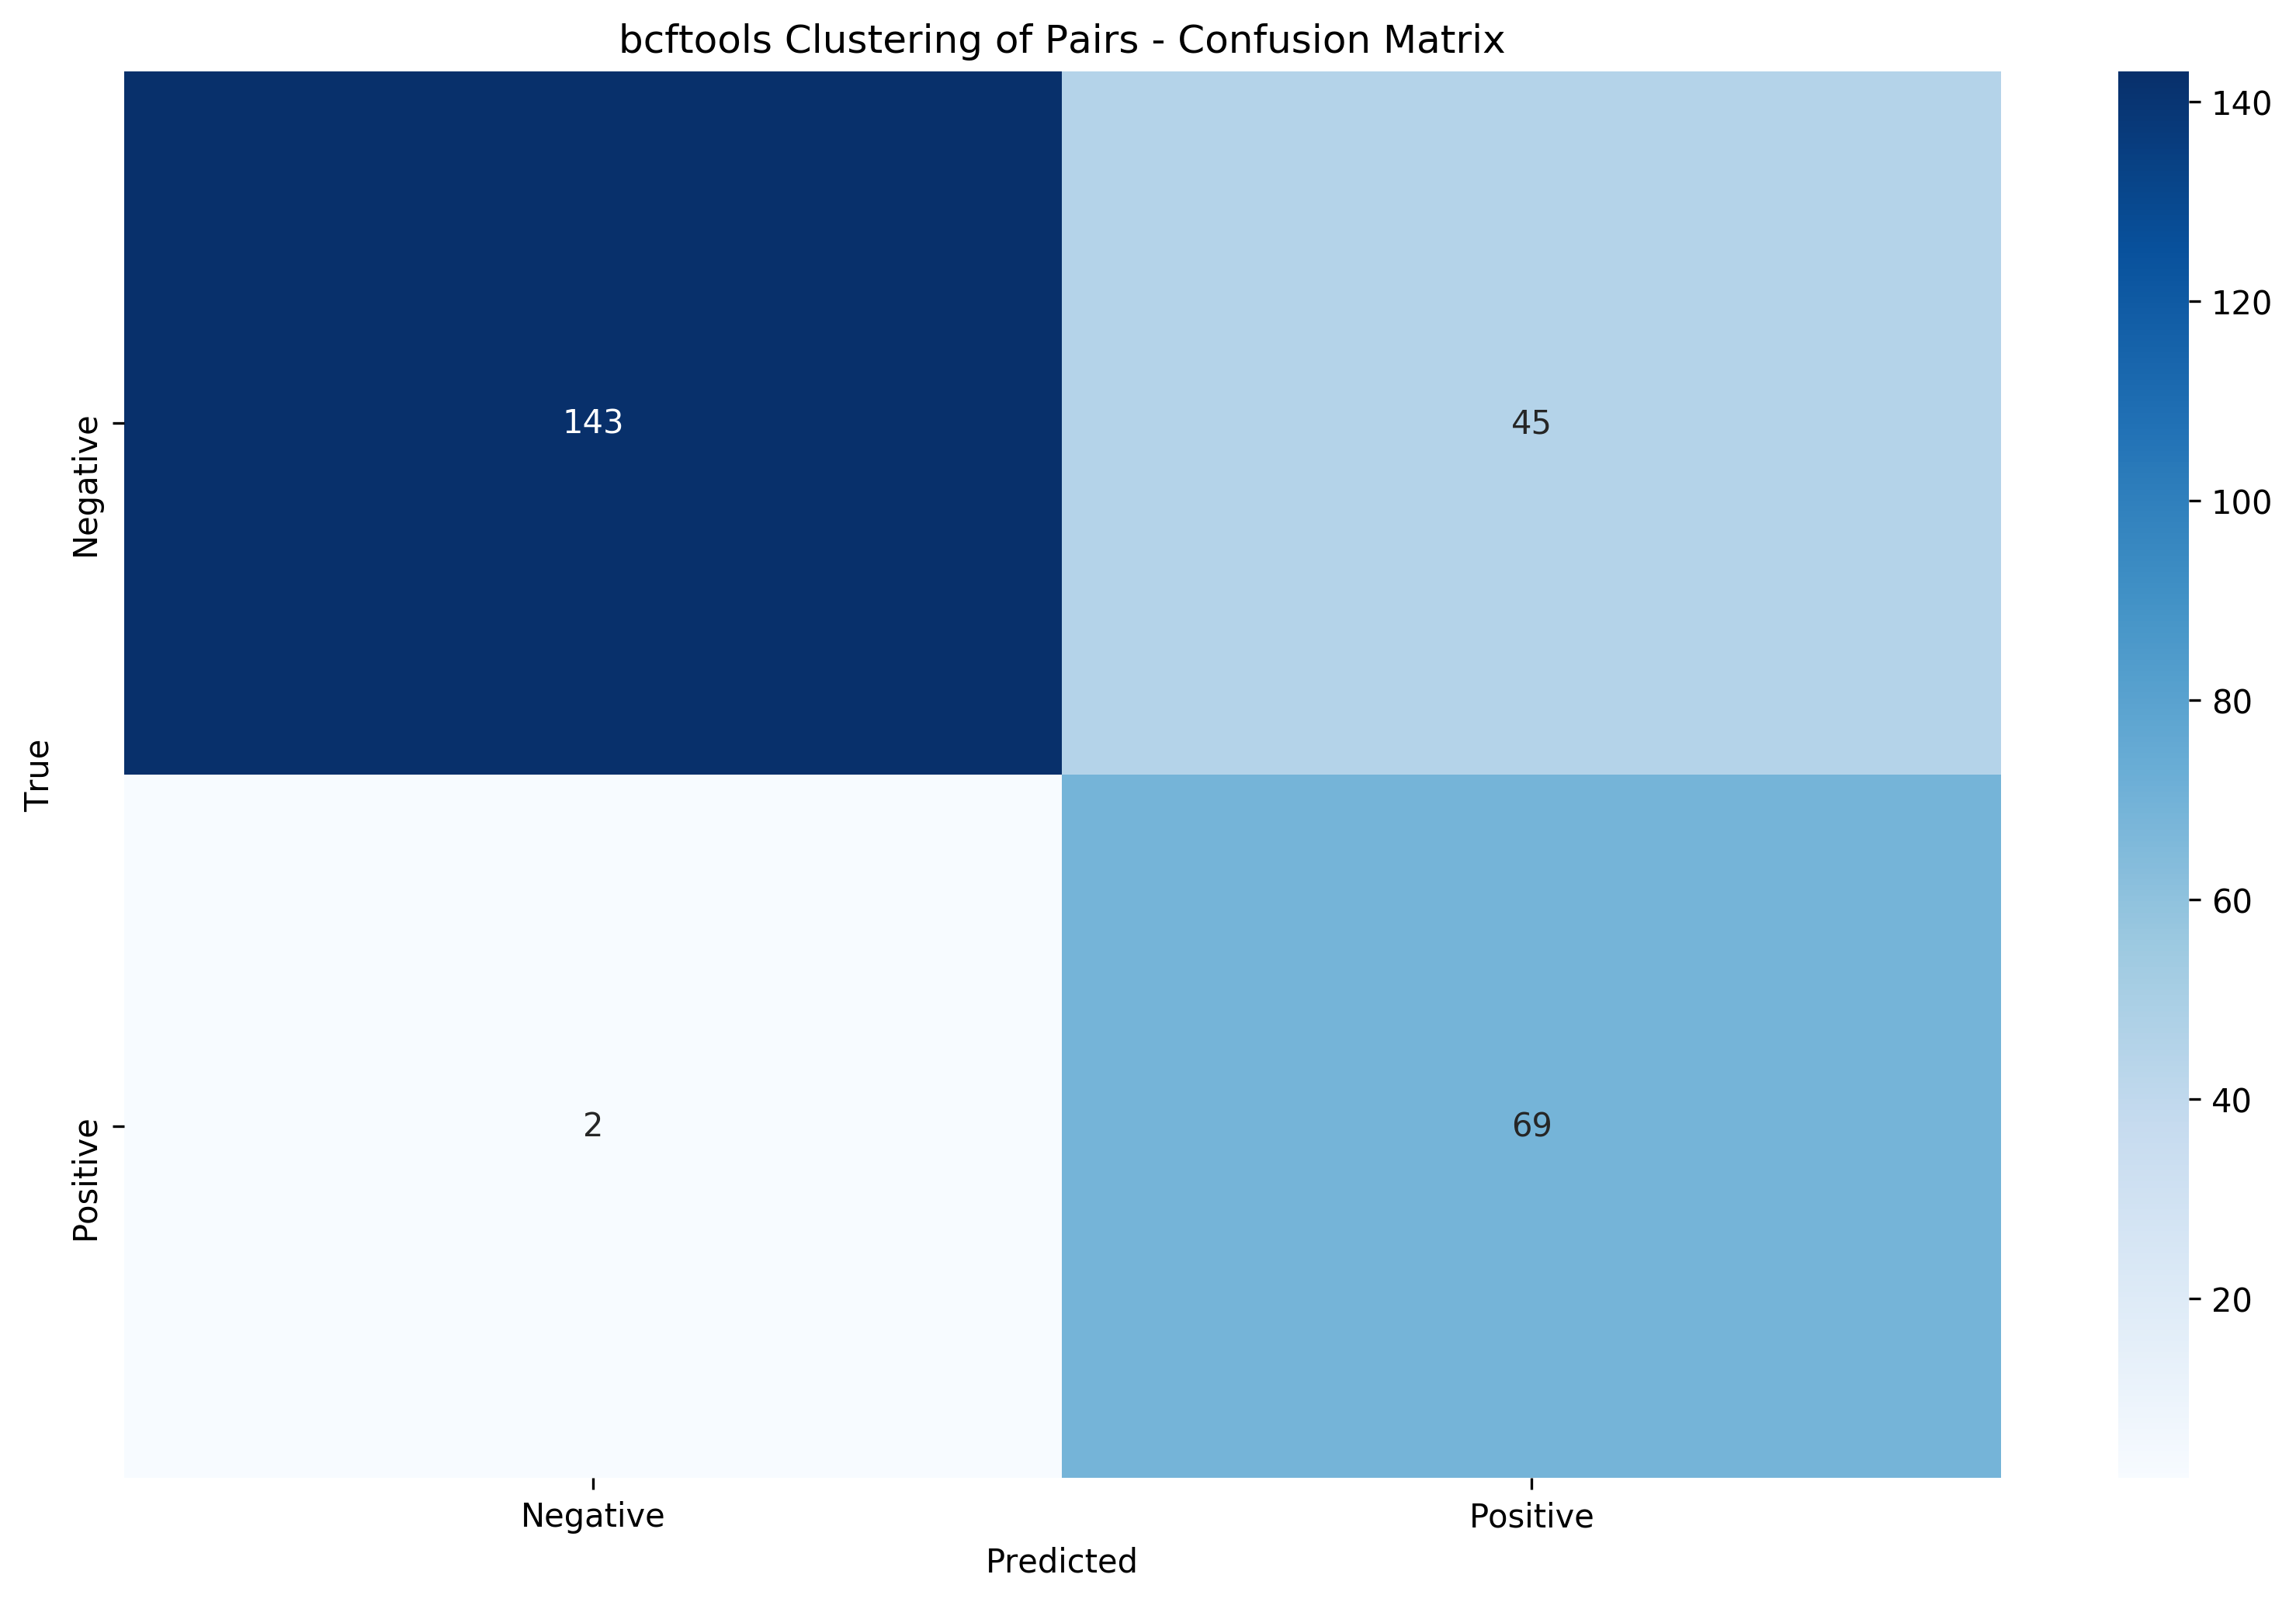

In [10]:
ax = plot_confusion_matrix(cm, "bcftools")

We can also calculate some summary metrics from this confusion matrix. Again, see [here](https://github.com/mbhall88/head_to_head_pipeline/issues/65#issuecomment-790368373) for more information on these metrics.

In [11]:
precision = cm.precision()
print(f"Precision: {precision}")
recall = cm.recall()
print(f"Recall: {recall}")
fmi = cm.fowlkes_mallows_index()
print(f"FMI: {fmi}")
mcc = cm.matthews_correlation_coefficient()
print(f"MCC: {mcc}")
f_score = cm.f_score()
print(f"F-score: {f_score}")
f_beta = cm.f_score(2.0)
print(f"F-beta: {f_beta} weighing recall twice as much as precision")
f_beta = cm.f_score(0.5)
print(f"F-beta: {f_beta} weighing precision twice as much as recall")

Precision: 0.6052631578947368
Recall: 0.971830985915493
FMI: 0.7669507751317335
MCC: 0.6582048671670166
F-score: 0.745945945945946
F-beta: 0.8668341708542714 weighing recall twice as much as precision
F-beta: 0.6546489563567361 weighing precision twice as much as recall


## `pandora map`

In [12]:
map_mtx = load_matrix("pandora_single.matrix.csv", name="pandora_single")[ix]
assert all(compass_mtx.index == map_mtx.index)
map_threshold_converter = fit(xs, map_mtx.to_list())
pandora_single_threshold = map_threshold_converter(THRESHOLD)
print(f"The pandora map SNP distance threshold is {pandora_single_threshold:.2f} - rounded to {int(round(pandora_single_threshold))}")
pandora_single_threshold = int(round(pandora_single_threshold))
G_pandora_single = dist_matrix_to_graph(map_mtx, threshold=pandora_single_threshold)
plot_graph(G_pandora_single, threshold=pandora_single_threshold, name="pandora map")

The pandora map SNP distance threshold is 23.77 - rounded to 24


In [13]:
pred: List[bool] = [clustered_together(u, v, G_pandora_single) for u, v in compass_mtx.index]
cm = ConfusionMatrix.from_predictions(pred, true)
cm

ConfusionMatrix(tp=60, tn=122, fp=66, fn=11)

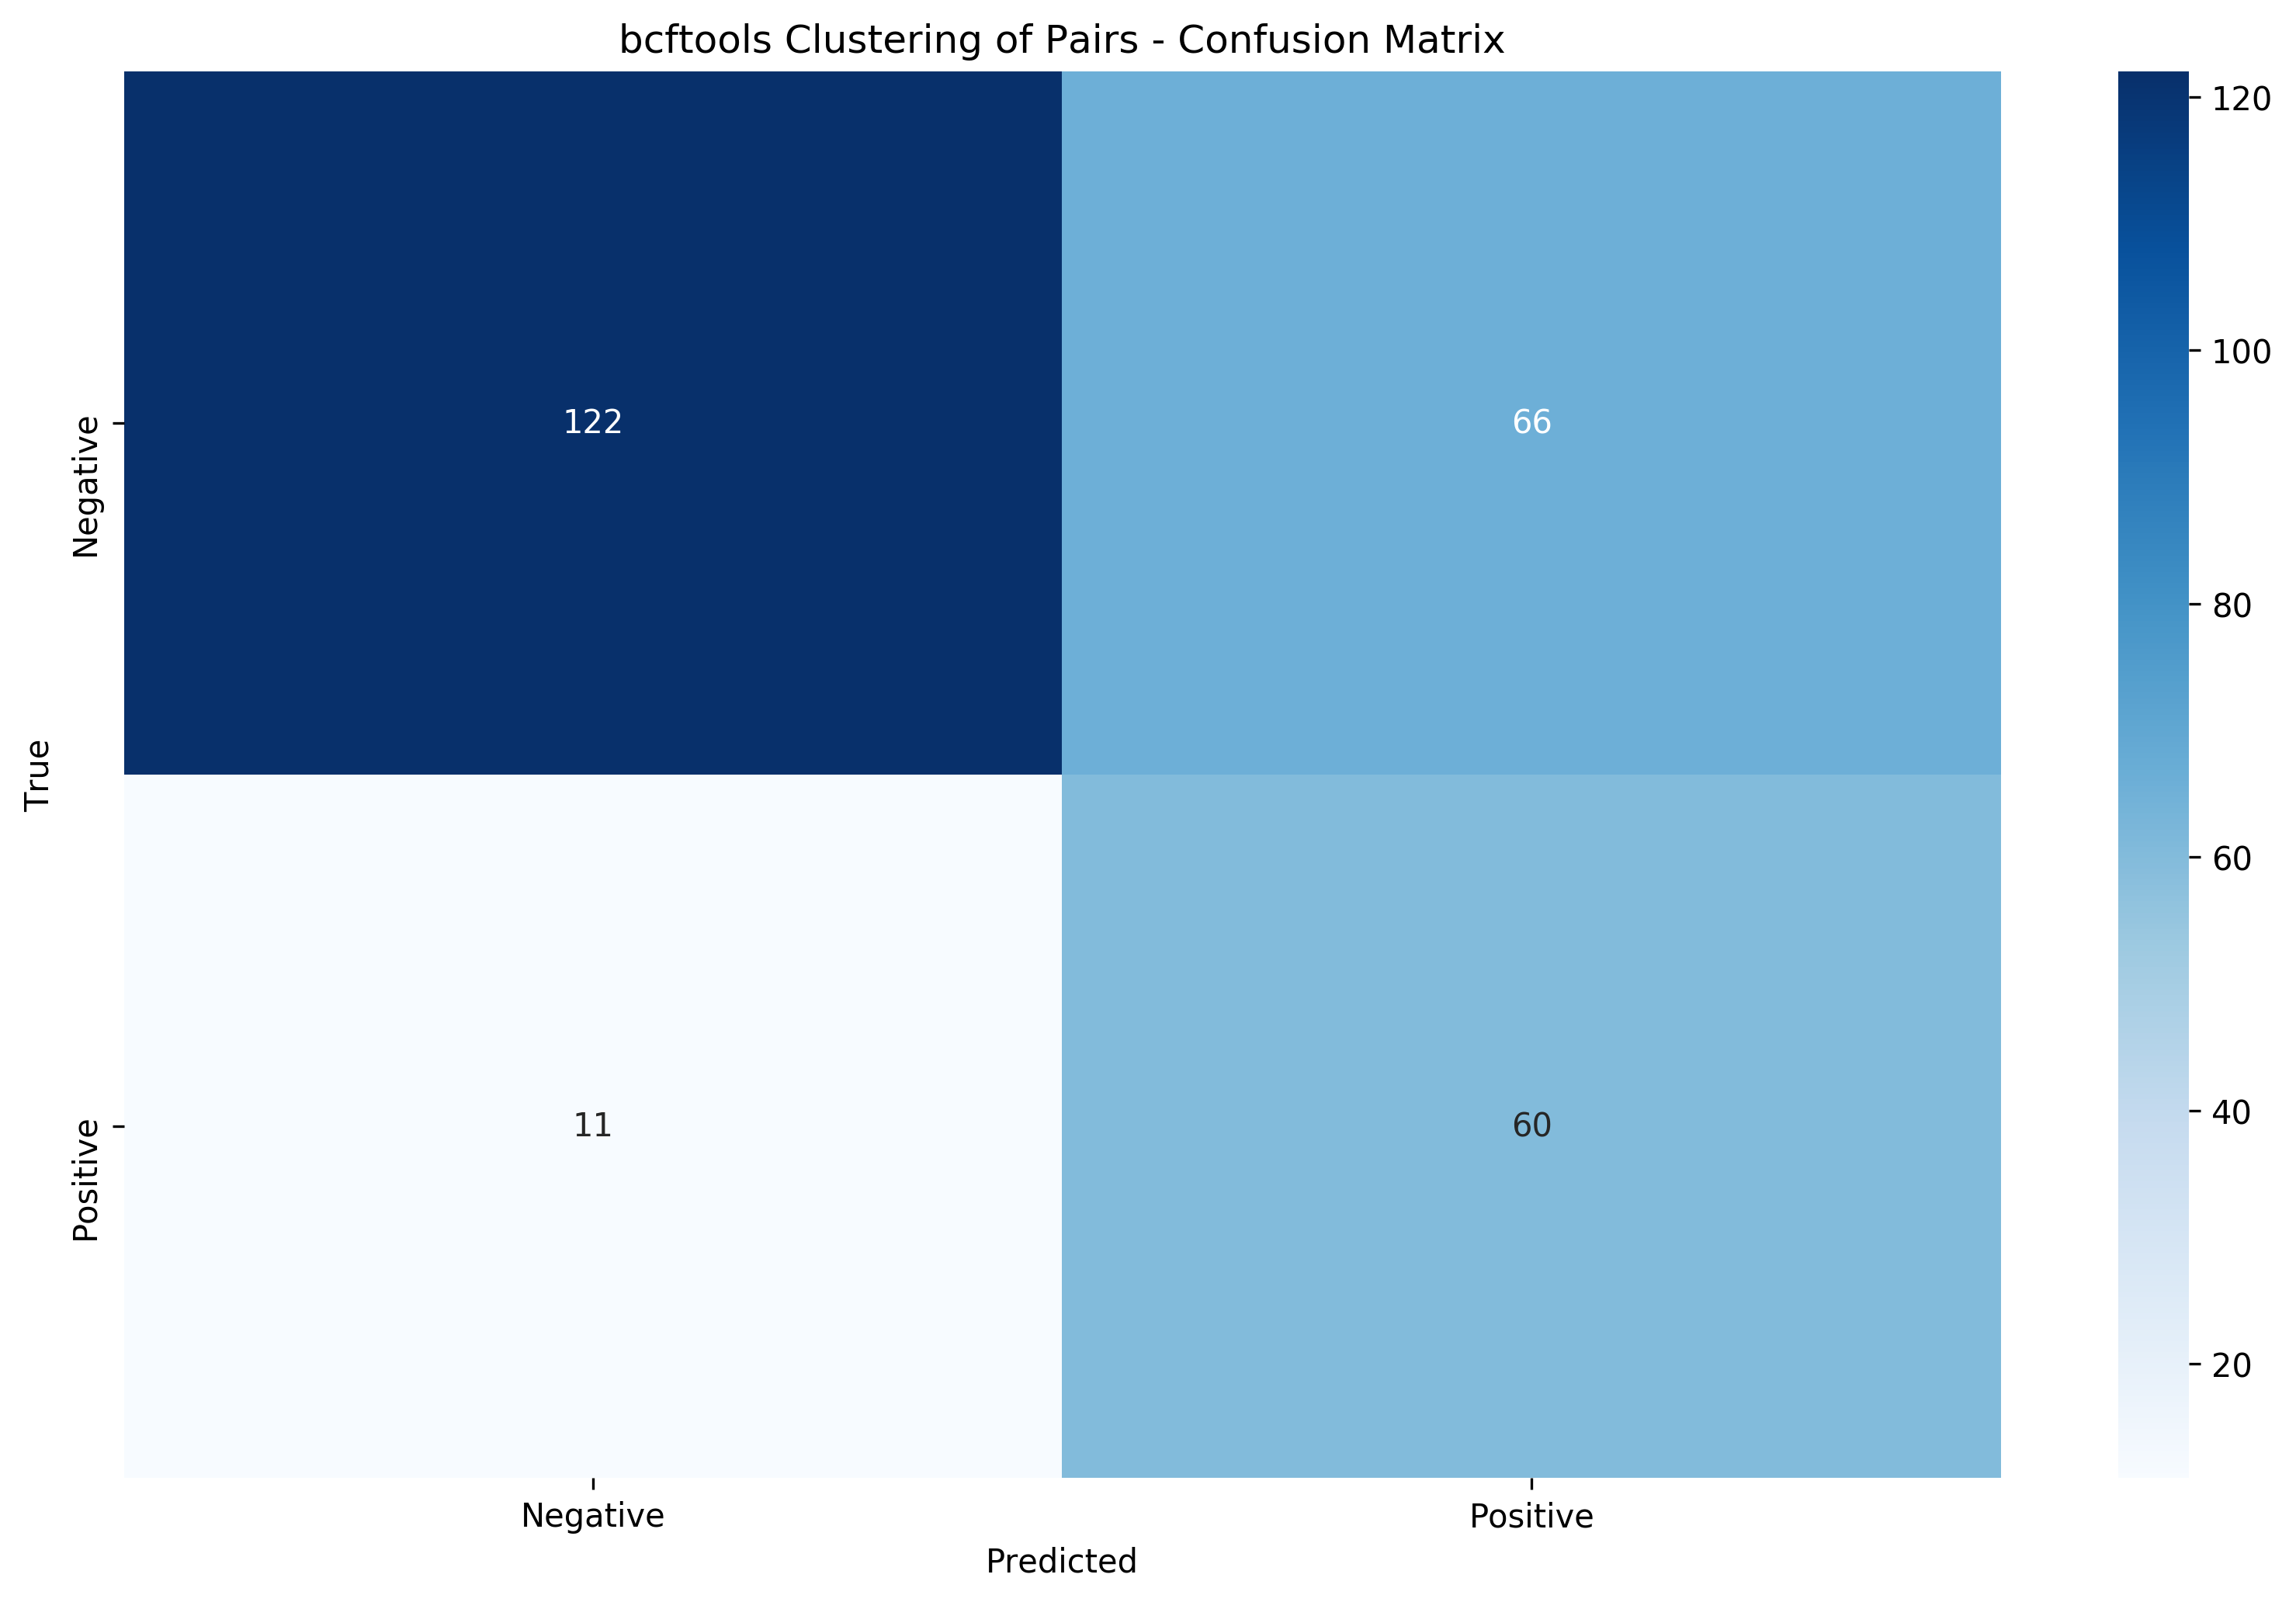

In [14]:
ax = plot_confusion_matrix(cm, "pandora map")

In [15]:
precision = cm.precision()
print(f"Precision: {precision}")
recall = cm.recall()
print(f"Recall: {recall}")
fmi = cm.fowlkes_mallows_index()
print(f"FMI: {fmi}")
mcc = cm.matthews_correlation_coefficient()
print(f"MCC: {mcc}")
f_score = cm.f_score()
print(f"F-score: {f_score}")
f_beta = cm.f_score(2.0)
print(f"F-beta: {f_beta} weighing recall twice as much as precision")
f_beta = cm.f_score(0.5)
print(f"F-beta: {f_beta} weighing precision twice as much as recall")

Precision: 0.47619047619047616
Recall: 0.8450704225352113
FMI: 0.6343614796955511
MCC: 0.4408894946807882
F-score: 0.6091370558375635
F-beta: 0.7317073170731706 weighing recall twice as much as precision
F-beta: 0.5217391304347826 weighing precision twice as much as recall


### `pandora compare`

In [16]:
compare_mtx = load_matrix("pandora_multi.matrix.csv", name="pandora_multi")[ix]
assert all(compass_mtx.index == compare_mtx.index)
compare_threshold_converter = fit(xs, compare_mtx.to_list())
pandora_multi_threshold = compare_threshold_converter(THRESHOLD)
print(f"The pandora compare SNP distance threshold is {pandora_multi_threshold:.2f} - rounded to {int(round(pandora_multi_threshold))}")
pandora_multi_threshold = int(round(pandora_multi_threshold))
G_pandora_multi = dist_matrix_to_graph(compare_mtx, threshold=pandora_multi_threshold)
plot_graph(G_pandora_multi, threshold=pandora_multi_threshold, name="pandora compare")

The pandora compare SNP distance threshold is 4.45 - rounded to 4


In [17]:
pred: List[bool] = [clustered_together(u, v, G_pandora_multi) for u, v in compass_mtx.index]
cm = ConfusionMatrix.from_predictions(pred, true)
cm

ConfusionMatrix(tp=43, tn=152, fp=36, fn=28)

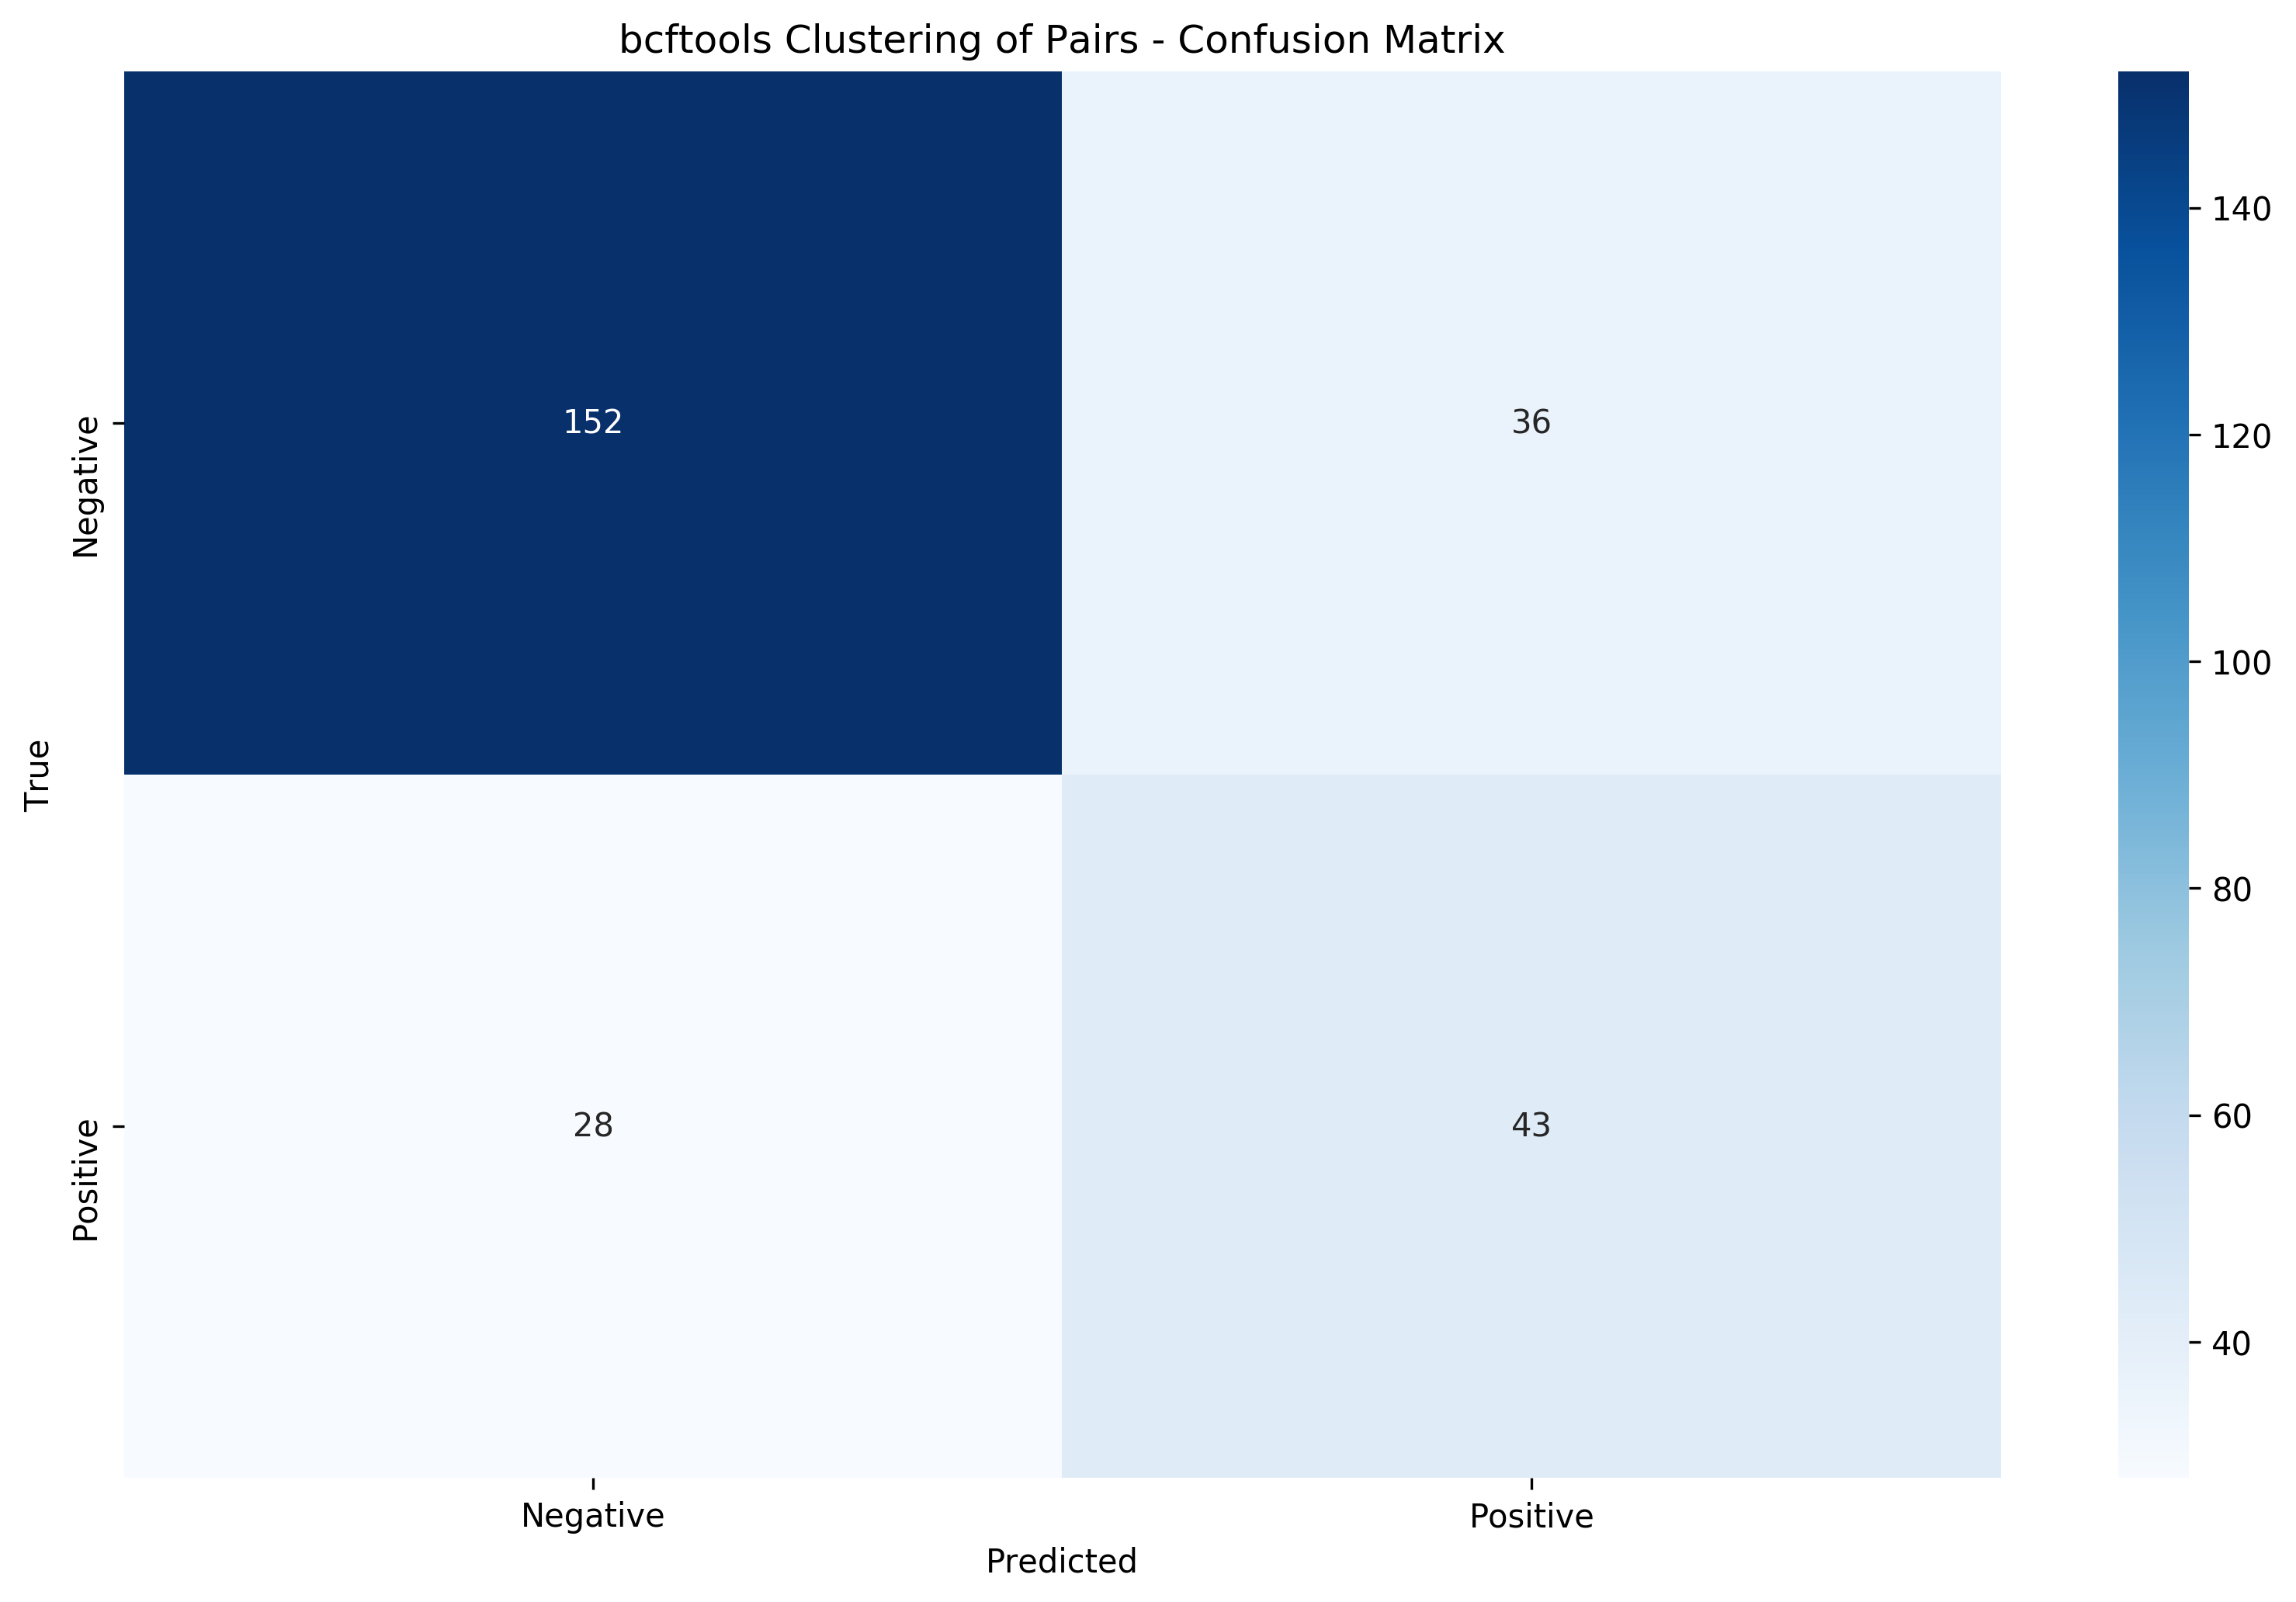

In [18]:
ax = plot_confusion_matrix(cm, "pandora compare")

In [19]:
precision = cm.precision()
print(f"Precision: {precision}")
recall = cm.recall()
print(f"Recall: {recall}")
fmi = cm.fowlkes_mallows_index()
print(f"FMI: {fmi}")
mcc = cm.matthews_correlation_coefficient()
print(f"MCC: {mcc}")
f_score = cm.f_score()
print(f"F-score: {f_score}")
f_beta = cm.f_score(2.0)
print(f"F-beta: {f_beta} weighing recall twice as much as precision")
f_beta = cm.f_score(0.5)
print(f"F-beta: {f_beta} weighing precision twice as much as recall")

Precision: 0.5443037974683544
Recall: 0.6056338028169014
FMI: 0.5741504844101762
MCC: 0.4012454652470566
F-score: 0.5733333333333334
F-beta: 0.5922865013774105 weighing recall twice as much as precision
F-beta: 0.5555555555555557 weighing precision twice as much as recall


# Threshold sweeps

### `bcftools`

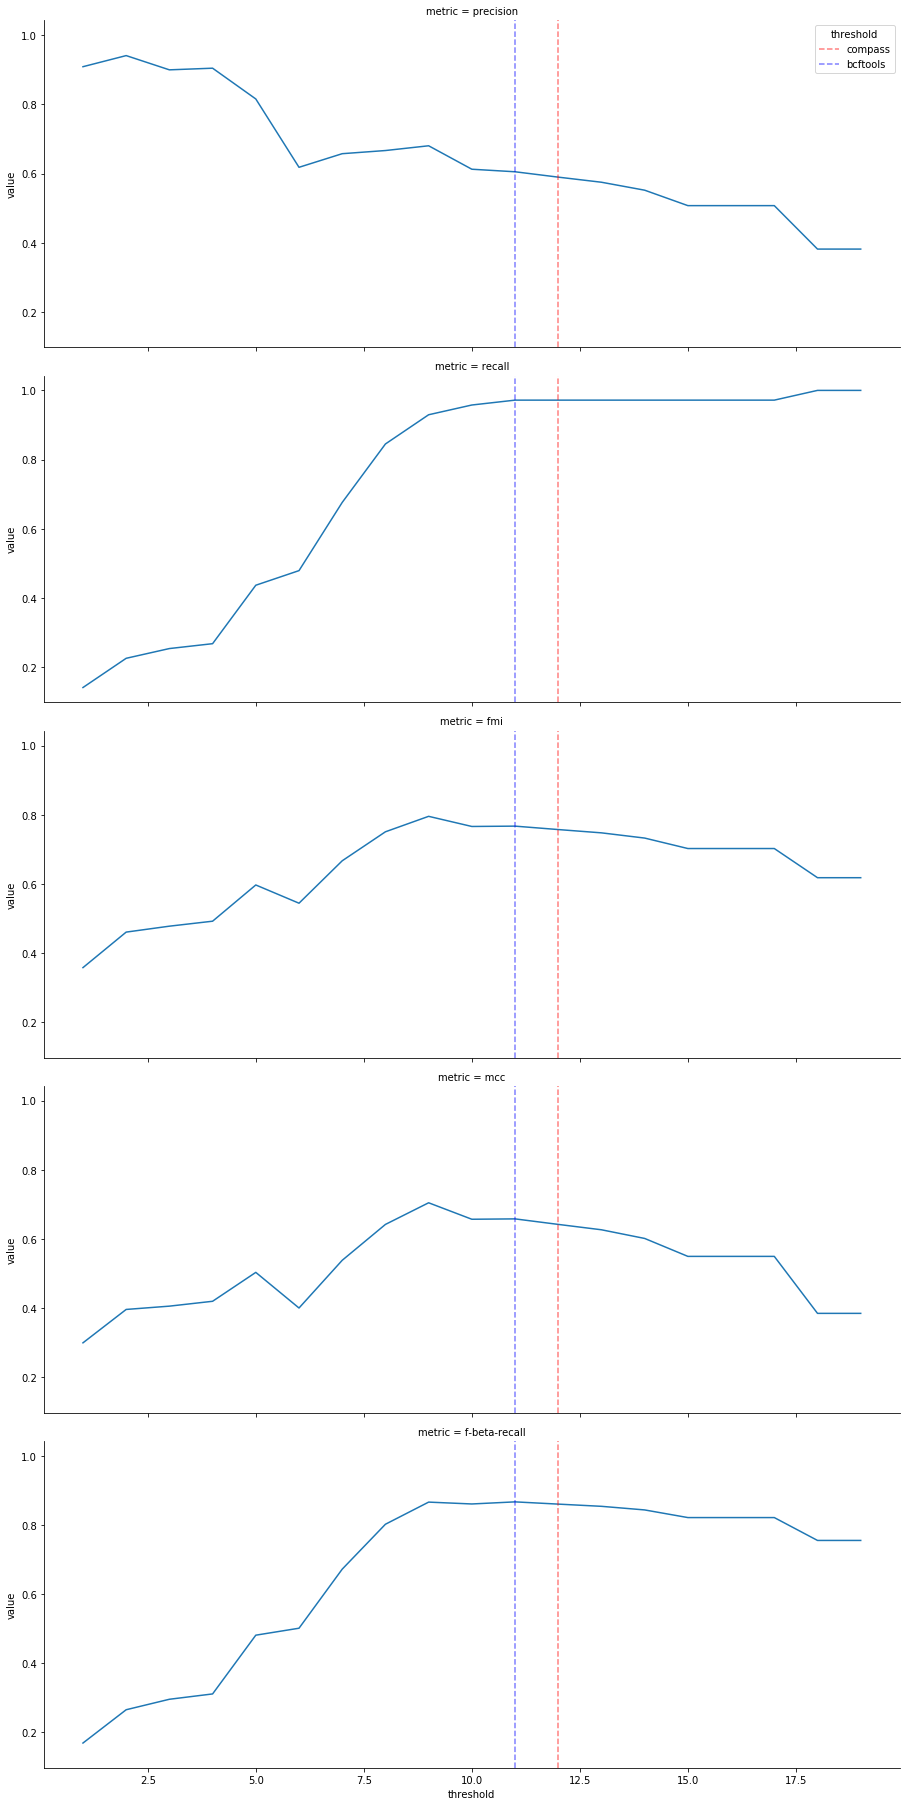

In [20]:
thresholds = list(range(1, 20))
data = []

for t in thresholds:
    G = dist_matrix_to_graph(bcftools_mtx, threshold=t)
    pred = [clustered_together(u, v, G) for u, v in compass_mtx.index]
    cm = ConfusionMatrix.from_predictions(pred, true)
    precision = cm.precision()
    recall = cm.recall()
    fmi = cm.fowlkes_mallows_index()
    mcc = cm.matthews_correlation_coefficient()
    f_beta = cm.f_score(beta=2.0)
    data.append((precision, recall, fmi, mcc, f_beta, t))
    
df = pd.DataFrame(data, columns=["precision", "recall", "fmi", "mcc", "f-beta-recall", "threshold"]).melt(id_vars="threshold", var_name="metric")
grid = sns.relplot(data=df, row="metric", x="threshold", y="value", kind="line", aspect=2.5, markers=True)
for ax in grid.axes:
    ax[0].axvline(THRESHOLD, color='red', ls='--', label="compass", alpha=0.5)
    ax[0].axvline(bcftools_threshold, color='blue', ls='--', label="bcftools", alpha=0.5)
_ = grid.axes[0][0].legend(title="threshold")

In [21]:
idx = df.groupby(["metric"])["value"].transform(max) == df["value"]
df[idx]

,threshold,metric,value
1,2,precision,0.941176
36,18,recall,1.000000
37,19,recall,1.000000
46,9,fmi,0.795296
65,9,mcc,0.704769
86,11,f-beta-recall,0.866834


### Conclusion

The **best threshold for a balance between precision and recall looks to be 9**. This yields precision and recall of

In [22]:
df.query("threshold == 9")

,threshold,metric,value
8,9,precision,0.680412
27,9,recall,0.929577
46,9,fmi,0.795296
65,9,mcc,0.704769
84,9,f-beta-recall,0.866142


The **best threshold if weighing recall twice as important as precision is 11**. This yields precision and recall of

In [23]:
df.query("threshold == 11")

,threshold,metric,value
10,11,precision,0.605263
29,11,recall,0.971831
48,11,fmi,0.766951
67,11,mcc,0.658205
86,11,f-beta-recall,0.866834


### `pandora map`

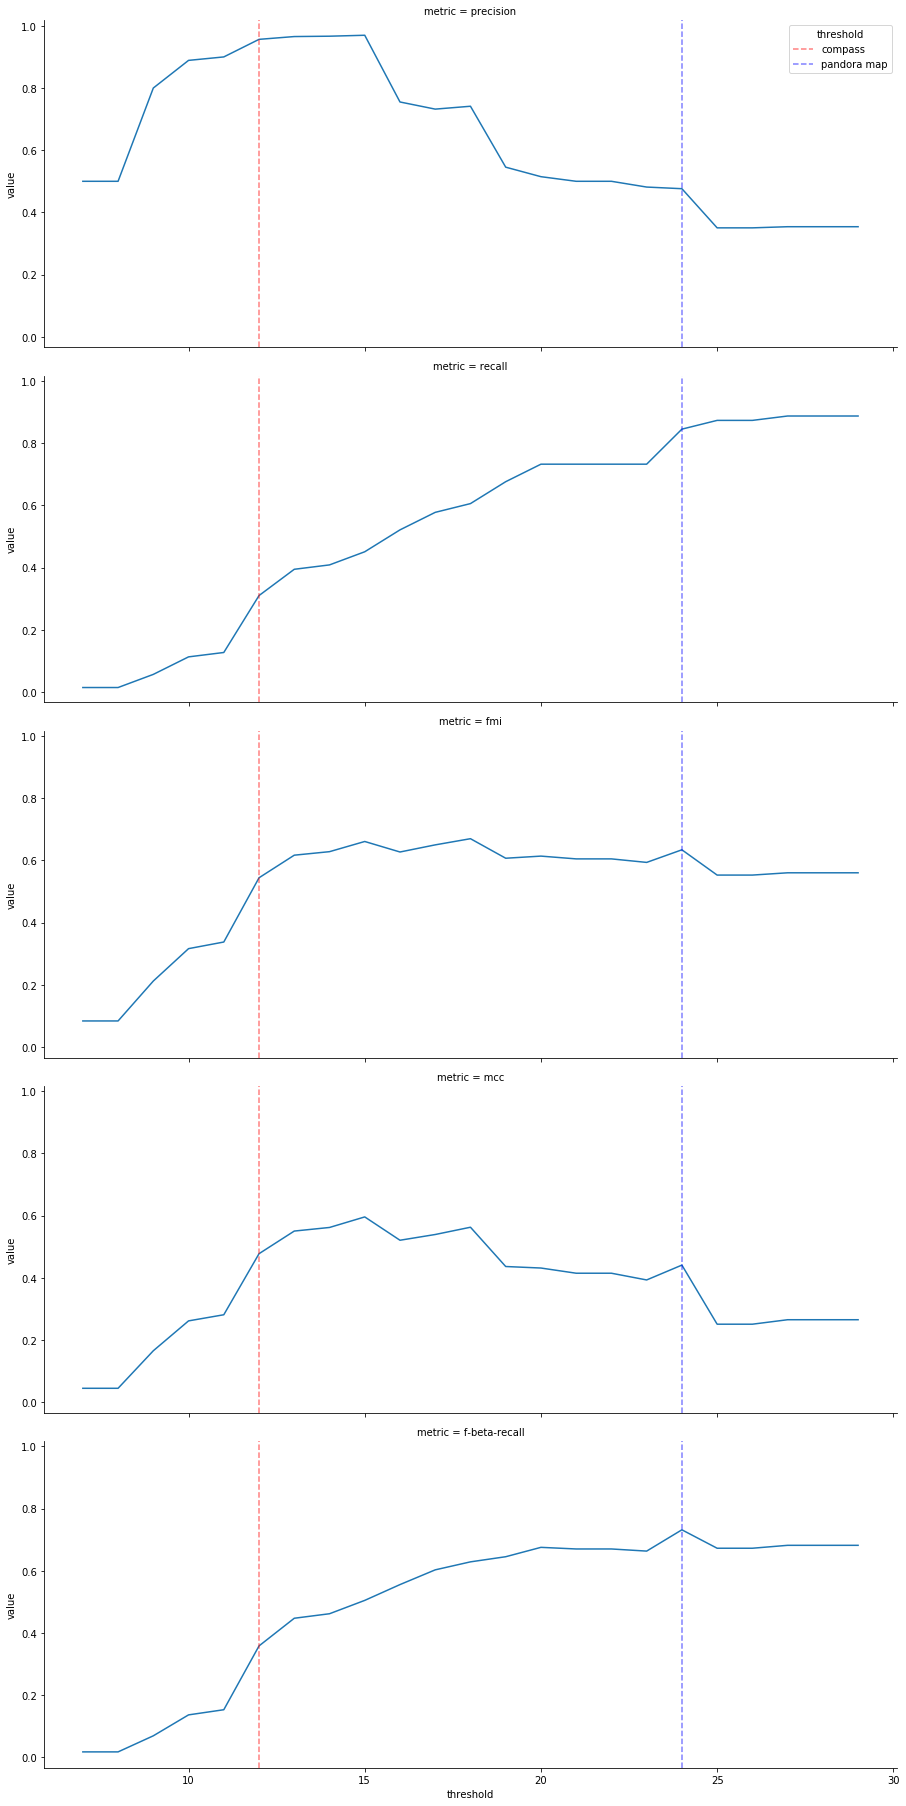

In [24]:
thresholds = list(range(7, 30))
data = []

for t in thresholds:
    G = dist_matrix_to_graph(map_mtx, threshold=t)
    pred = [clustered_together(u, v, G) for u, v in compass_mtx.index]
    cm = ConfusionMatrix.from_predictions(pred, true)
    precision = cm.precision()
    recall = cm.recall()
    fmi = cm.fowlkes_mallows_index()
    mcc = cm.matthews_correlation_coefficient()
    f_beta = cm.f_score(beta=2.0)
    data.append((precision, recall, fmi, mcc, f_beta, t))
    
df = pd.DataFrame(data, columns=["precision", "recall", "fmi", "mcc", "f-beta-recall", "threshold"]).melt(id_vars="threshold", var_name="metric")
grid = sns.relplot(data=df, row="metric", x="threshold", y="value", kind="line", aspect=2.5, markers=True)
for ax in grid.axes:
    ax[0].axvline(THRESHOLD, color='red', ls='--', label="compass", alpha=0.5)
    ax[0].axvline(pandora_single_threshold, color='blue', ls='--', label="pandora map", alpha=0.5)
_ = grid.axes[0][0].legend(title="threshold")

In [26]:
idx = df.groupby(["metric"])["value"].transform(max) == df["value"]
df[idx]

,threshold,metric,value
8,15,precision,0.969697
43,27,recall,0.887324
44,28,recall,0.887324
45,29,recall,0.887324
57,18,fmi,0.670078
77,15,mcc,0.595844
109,24,f-beta-recall,0.731707


### Conclusion

The **best threshold for a balance between precision and recall looks to be 15 or 18**. This yields precision and recall of

In [27]:
df.query("threshold == 15")

,threshold,metric,value
8,15,precision,0.969697
31,15,recall,0.450704
54,15,fmi,0.661095
77,15,mcc,0.595844
100,15,f-beta-recall,0.504732


In [28]:
df.query("threshold == 18")

,threshold,metric,value
11,18,precision,0.741379
34,18,recall,0.605634
57,18,fmi,0.670078
80,18,mcc,0.562672
103,18,f-beta-recall,0.628655


The **best threshold if weighing recall twice as important as precision is 24**. This yields precision and recall of

In [29]:
df.query("threshold == 24")

,threshold,metric,value
17,24,precision,0.476190
40,24,recall,0.845070
63,24,fmi,0.634361
86,24,mcc,0.440889
109,24,f-beta-recall,0.731707


### `pandora compare`

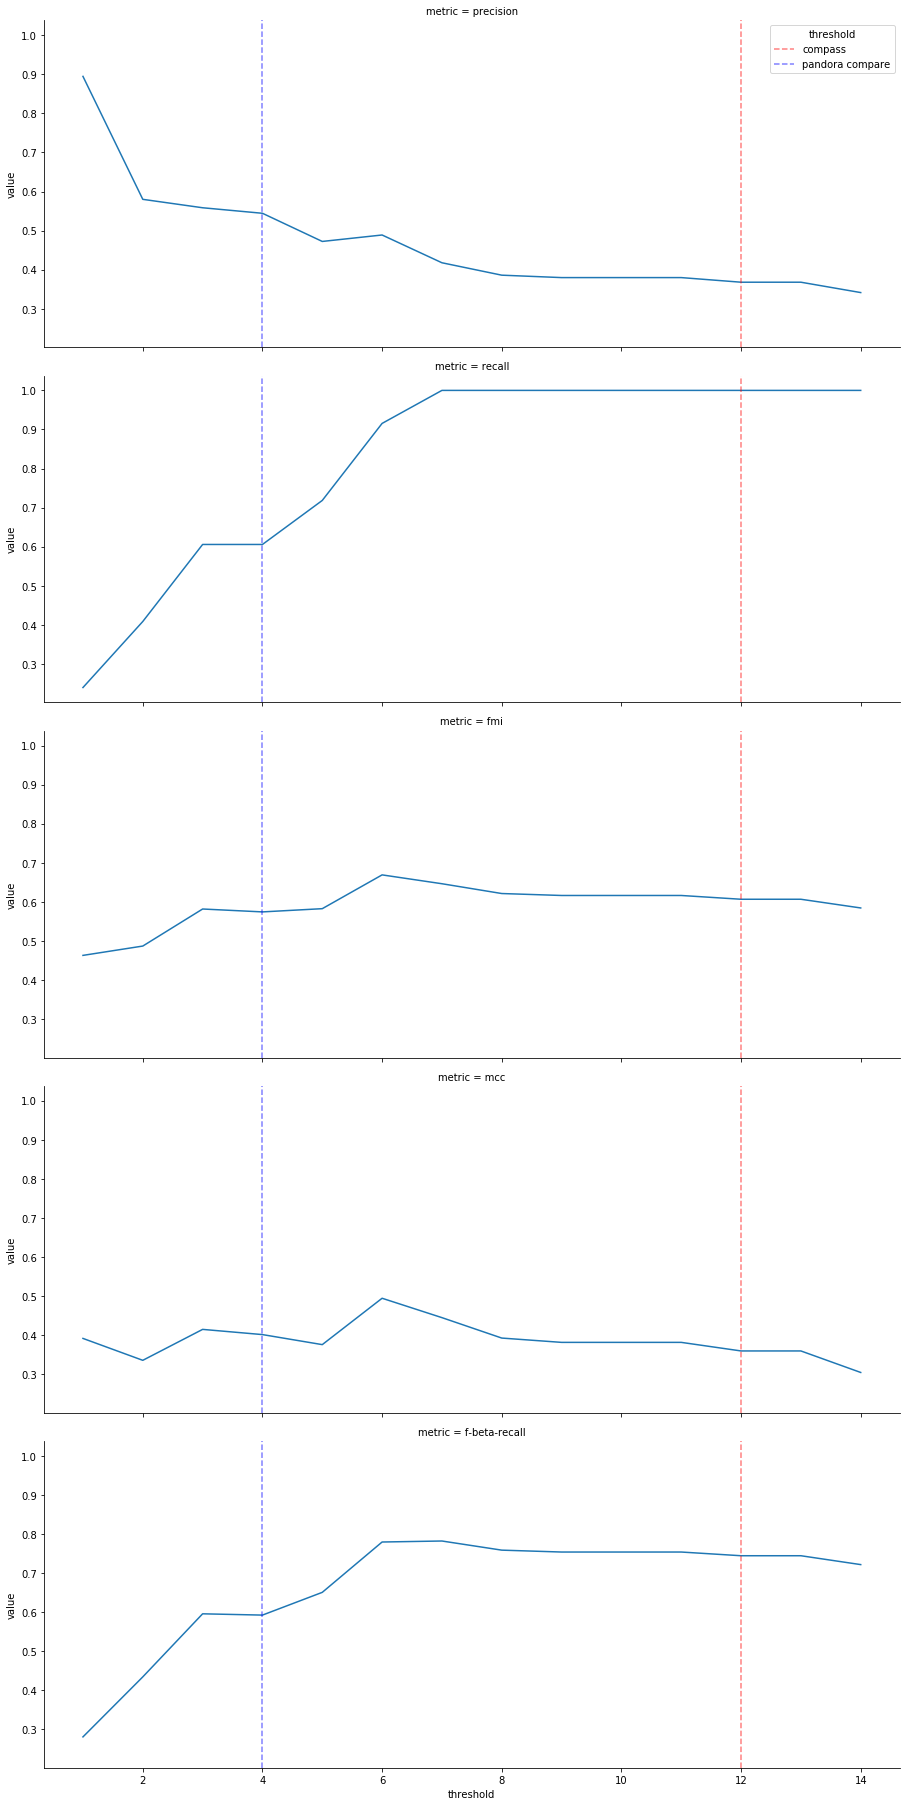

In [30]:
thresholds = list(range(1, 15))
data = []

for t in thresholds:
    G = dist_matrix_to_graph(compare_mtx, threshold=t)
    pred = [clustered_together(u, v, G) for u, v in compass_mtx.index]
    cm = ConfusionMatrix.from_predictions(pred, true)
    precision = cm.precision()
    recall = cm.recall()
    fmi = cm.fowlkes_mallows_index()
    mcc = cm.matthews_correlation_coefficient()
    f_beta = cm.f_score(beta=2.0)
    data.append((precision, recall, fmi, mcc, f_beta, t))
    
df = pd.DataFrame(data, columns=["precision", "recall", "fmi", "mcc", "f-beta-recall", "threshold"]).melt(id_vars="threshold", var_name="metric")
grid = sns.relplot(data=df, row="metric", x="threshold", y="value", kind="line", aspect=2.5, markers=True)
for ax in grid.axes:
    ax[0].axvline(THRESHOLD, color='red', ls='--', label="compass", alpha=0.5)
    ax[0].axvline(pandora_multi_threshold, color='blue', ls='--', label="pandora compare", alpha=0.5)
_ = grid.axes[0][0].legend(title="threshold")

In [31]:
idx = df.groupby(["metric"])["value"].transform(max) == df["value"]
df[idx]

,threshold,metric,value
0,1,precision,0.894737
20,7,recall,1.000000
21,8,recall,1.000000
22,9,recall,1.000000
23,10,recall,1.000000
24,11,recall,1.000000
25,12,recall,1.000000
26,13,recall,1.000000
27,14,recall,1.000000
33,6,fmi,0.668896


### Conclusion

The **best threshold for a balance between precision and recall (or if weighing recall twice as much as precision) looks to be 6**. This yields precision and recall of

In [32]:
df.query("threshold == 6")

,threshold,metric,value
5,6,precision,0.488722
19,6,recall,0.915493
33,6,fmi,0.668896
47,6,mcc,0.494246
61,6,f-beta-recall,0.779376
